# Test of komet

1. Downloading the dataset (train/val/test) : you can choose different databases 
2. Calculating of molecule features
3. Loading approximated protein features, using SVD of the Local Alignment kernel precalculated on 20605 human proteins
4. Testing with a chosen lambda

In [5]:
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import  average_precision_score,  roc_curve, confusion_matrix, precision_score, recall_score, auc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
device_cpu = device
print( device )

mytype = torch.float16 # to save memory (only on GPU)
mytype = torch.float32

cpu


In [6]:
import sys
sys.path.append('../')  # Ajoute le répertoire parent au chemin de recherche des modules
import komet 

cpu


In [7]:
# pour connaitre dans quel repertoire on ets
import os

os.getcwd()

'/Users/gguichaoua/Dropbox/gwenn/these/chemogenomique/Komet/ipynb'

### 1. Downloading the dataset (train/val/test) : you can choose different databases 

In [8]:
path_data_set = 'BIOSNAP/full_data'
path_data_set = 'BIOSNAP/unseen_protein'
path_data_set = 'BIOSNAP/unseen_drug'

path_data_set = 'BindingDB'

path_data_set = 'LCIdb/Double_Orphans'

In [9]:
data_dir = '../data/'
dataset_dir = data_dir + path_data_set

# load data
train = Komet.load_df("train.csv.zip",dataset_dir)
val = Komet.load_df("val.csv",dataset_dir)
test = Komet.load_df("test.csv",dataset_dir)

# dataframe full has all smiles and fasta sequences
full = pd.concat([train, val, test])
print("full shape",full.shape)

number of smiles to clean: 0
train.csv shape (236530, 3)
number of smiles to clean: 0
val.csv shape (21844, 3)
number of smiles to clean: 0
test.csv shape (45005, 3)
full shape (303379, 3)


### 2. Molecule features
#!pip install rdkit

In [ ]:
#### MOLECULE####

list_smiles = full[['SMILES']].drop_duplicates().values.flatten()
nM = len(list_smiles)
print("number of different smiles (mol):",nM)

# add indsmiles in train, val, test
#dict_ind2smiles = {i:list_smiles[i] for i in range(nM)}
dict_smiles2ind = {list_smiles[i]:i for i in range(nM)}
train['indsmiles'] = train['SMILES'].apply(lambda x:dict_smiles2ind[x] )
val['indsmiles'] = val['SMILES'].apply(lambda x: dict_smiles2ind[x])
test['indsmiles'] = test['SMILES'].apply(lambda x: dict_smiles2ind[x])

number of different smiles (mol): 143255


#### a. Nystrom approx Tanimoto kernel

In [13]:
# molecule kernel_first step : compute Morgan FP for each smiles of all the dataset
MorganFP = Komet.Morgan_FP(list_smiles)

# compute the Nystrom approximation of the mol kernel 
mM = 3000 #all mol to compute the mol kernel for medium-scale database
dM = 1000 #all dim for the mol features for medium-scale database

# In case there are less molecules than the number of molecules to compute the Nystrom approximation
mM = min(mM,nM) # number of molecule to compute nystrom
dM = min(dM,nM) # final dimension of features for molecules
print("mM",mM,"dM",dM)

# compute the Nystrom approximation of the mol kernel and the features of the Kronecker kernel (features nodmalized and calculated on all mol contained in the dataset (train/val/test))
X_cn = Komet.Nystrom_X_cn(mM,dM,nM,MorganFP)

cpu
mM 3000 dM 1000
mol kernel shape torch.Size([3000, 143255])


### b. Morgan fingerprint (ECFP4)

In [14]:
# mol features : Morgan fingerprint (ECFP4)
X = Komet.Morgan_FP(smiles)
X = torch.tensor(X,dtype = mytype,device = device)
X_c = X - X.mean(axis = 0)
X_cn = X_c / torch.norm(X_c,dim = 1)[:,None]

cpu


/var/folders/zg/y03kdtc553xg5q1ct59rj44c0000gn/T/ipykernel_83647/1192971215.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X,dtype = mytype,device = device)


### c. Mol2Vec

In [16]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.
    
    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """
    
    keys = set(model.wv.key_to_index)
    vec = []
    
    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence 
                            if y in set(sentence) & keys]))
    return np.array(vec)


model = word2vec.Word2Vec.load('/Users/gguichaoua/Dropbox/gwenn/these/Cluster/ConPLex_dev/models/model_300dim.pkl')

from rdkit import Chem
X = []
for s in smiles: 
    m = Chem.MolFromSmiles(s)
    sentence = MolSentence(mol2alt_sentence(m,1))  #radius = 1
    wide_vector = sentences2vec(sentence,model, unseen="UNK")
    feats = wide_vector.mean(axis=0)
    feats = torch.from_numpy(feats).squeeze().float()
    X.append(feats)
X = torch.stack(X)
X_c = X - X.mean(axis = 0)
X_cn = X_c / torch.norm(X_c,dim = 1)[:,None]
X_cn = torch.tensor(X_cn,dtype = mytype,device = device)
len(X)

/var/folders/zg/y03kdtc553xg5q1ct59rj44c0000gn/T/ipykernel_83647/1019744889.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_cn = torch.tensor(X_cn,dtype = mytype,device = device)


143255

### 3. Protein features

In [17]:
# Index of the protein in the dataset
fasta = full[['Target Sequence']].drop_duplicates().values.flatten() # fasta sequence on the dataset, in the same order as the dataset
print("number of different Fasta (protein):",len(fasta))
# add ind_fasta dans train, val et test
train['indfasta'] = train['Target Sequence'].apply(lambda x: np.where(fasta==x)[0][0])
val['indfasta'] = val['Target Sequence'].apply(lambda x: np.where(fasta==x)[0][0])
test['indfasta'] = test['Target Sequence'].apply(lambda x:  np.where(fasta==x)[0][0])

cpu
number of different Fasta (protein): 2069


### a. SVD of LAkernel

In [18]:
# Load Protein kernel and dictionary of index
dict_ind2fasta_all = pickle.load(open(data_dir + "/dict_ind2fasta_all.data", 'rb'))
dict_fasta2ind_all = {fasta:ind for ind,fasta in dict_ind2fasta_all.items()}
with open(data_dir + "/dict_ind2fasta_all_K_prot.data", 'rb') as f:
    KP_all = pickle.load(f)
KP_all.shape, type(KP_all)

FileNotFoundError: [Errno 2] No such file or directory: '../data//dict_ind2fasta_all_K_prot.data'

In [ ]:
# Protein kernel for the dataset
I_fasta = [dict_fasta2ind_all[fasta[i]] for i in range(len(fasta))] # index of fasta in the precomputed dict and protein kernel, in the same order as the dataset
KP = KP_all[I_fasta,:][:,I_fasta]
KP = torch.tensor(KP, dtype=mytype).to(device)
print("kernel prot shape",KP.shape)

kernel prot shape torch.Size([2069, 2069])


In [ ]:
# computation of feature for protein (no nystrom, just SVD)
rP = KP.shape[0]#min(KP.shape[0],500)
U, Lambda, VT = torch.svd(KP)
Y = U[:,:rP] @ torch.diag(torch.sqrt(Lambda[:rP]))

# nomramlisation of the features
Y_c = Y - Y.mean(axis = 0)
Y_cn = Y_c / torch.norm(Y_c,dim = 1)[:,None]

### B. Protbert

In [ ]:
from ConPLex_dev.src.featurizers.protein import ProtBertFeaturizer
target_featurizer = ProtBertFeaturizer(save_dir="./save_embed", per_tok=False).cuda(device)
target_featurizer.preload(full['Target Sequence'].unique())
Y = [target_featurizer(f) for f in fasta]
# nomramlisation of the features
Y = torch.stack(Y)
Y_c = Y - Y.mean(axis = 0)
Y_cn = Y_c / torch.norm(Y_c,dim = 1)[:,None]
len(Y)

### Other from Complex

In [ ]:
from ConPLex_dev.src.featurizers.protein import ESMFeaturizer,ProtT5XLUniref50Featurizer,ProseFeaturizer
target_featurizer = ESMFeaturizer(save_dir="./save_embed", per_tok=False).cuda(device)
#target_featurizer = ProtT5XLUniref50Featurizer(save_dir="./save_embed", per_tok=False).cuda(device)
#target_featurizer = ProseFeaturizer(save_dir="./save_embed", per_tok=False).cuda(device)
target_featurizer.preload(full['Target Sequence'].unique())
Y = [target_featurizer(f) for f in fasta]
# nomramlisation of the features
Y = torch.stack(Y)
Y_c = Y - Y.mean(axis = 0)
Y_cn = Y_c / torch.norm(Y_c,dim = 1)[:,None]
len(Y)

### INDEX OF INTERACTIONS

In [30]:
# TRAIN
I, J, y = Komet.load_datas(train)
n = len(I)
print("len(train)",n)

len(train) 236530


### SVM


In [31]:
lamb = 1e-6

# train the model
w_bfgs,b_bfgs = Komet.SVM_bfgs(X_cn,Y_cn,y,I,J,lamb)
# compute a probability using weights (Platt scaling)
s,t = Komet.compute_proba_Platt_Scalling(w,X_cn,Y_cn,y,I,J)

L-BFGS time: 208.1987 seconds


In [ ]:
# TEST 
I_test, J_test, y_test = Komet.load_datas("test.csv")
n_test = len(I_test)
print("len(test)",n_test)

In [ ]:
#### TEST ####
# we test the model on the test set
# we compute a probability using weights (Platt scaling)
y_pred_test, proba_pred_test = Komet.compute_proba(w_bfgs,b_bfgs,s,t,X_cn,Y_cn,I_test,J_test)
# we compute the results
acc1,au_Roc,au_PR,acc_best,FP = Komet.results(y_test.cpu(),y_pred_test.cpu(),proba_pred_test.cpu())

### validation (choice of $\lambda$)

In [35]:
#VALIDATION 
I_val, J_val, y_val = Komet.load_datas(val)
n_val = len(I_val)
print("len(val)",n_val)

len(val) 21844


In [36]:
# we compute a probability using weights (Platt scaling)
y_pred, proba_pred = Komet.compute_proba(w,b,s,t,X_cn,Y_cn,I_val,J_val)
# we compute the results
acc1,au_Roc,au_PR,acc_best,FP = Komet.results(y_val.cpu(),y_pred.cpu(),proba_pred.cpu())

accuracy (threshold 0.5)= 0.5442226529121399
roc AUC:0.7673417850891948
aupr= 0.8052481767994024
optimal threshold: 0.072426796
accuracy (best threshold)= 0.712964653968811
Confusion Matrix with best threshold: 
 [[8267 2655]
 [3615 7307]]
False Positive Rate with best threshold:  0.24308734663980955


In [20]:
#### Choice of the hyperparameters ####
# we use the validation set to choose the hyperparameters
# we use the AUPR as a criterion
lambdas = np.logspace(-11, 2, num=14)
accs = []
aupr = []
lambda_max = 0
aupr_max = 0

for lamb in lambdas:
    print("lambda=",lamb)

    # train the model
    w,b = Komet.SVM_bfgs(X_cn,Y_cn,y,I,J,lamb)
    # compute a probability using weights (Platt scaling)
    s,t = Komet.compute_proba_Platt_Scalling(w,X_cn,Y_cn,y,I,J)

    # we test the model on the validation set
    # we compute a probability using weights (Platt scaling)
    y_pred, proba_pred = compute_proba(w,b,s,t,X_cn,Y_cn,I_val,J_val)
    # we compute the results
    acc1,au_Roc,au_PR,acc_best,FP = results(y_val.cpu(),y_pred.cpu(),proba_pred.cpu())
    accs.append(acc1)
    aupr.append(au_PR)

    if au_PR > aupr_max:
        lambda_max=lamb
        aupr_max = au_PR

print("lambda_max",lambda_max)
print("aupr_max for val",aupr_max)


lambda= 1e-11
L-BFGS time: 86.0356 seconds
accuracy (threshold 0.5)= 0.8419150710105896
roc AUC:0.9083730903647832
aupr= 0.6750785577914972
optimal threshold: 0.3419631
accuracy (best threshold)= 0.8288165926933289
Confusion Matrix with best threshold: 
 [[4700 1015]
 [ 122  805]]
False Positive Rate with best threshold:  0.17760279965004375
lambda= 1e-10
L-BFGS time: 84.5113 seconds
accuracy (threshold 0.5)= 0.8289671540260315
roc AUC:0.9043180147249664
aupr= 0.65638850488429
optimal threshold: 0.40460488
accuracy (best threshold)= 0.8282144069671631
Confusion Matrix with best threshold: 
 [[4710 1005]
 [ 136  791]]
False Positive Rate with best threshold:  0.17585301837270342
lambda= 1e-09
L-BFGS time: 83.7543 seconds
accuracy (threshold 0.5)= 0.8322794437408447
roc AUC:0.9055372932752338
aupr= 0.6691062563722949
optimal threshold: 0.39101088
accuracy (best threshold)= 0.8252032399177551
Confusion Matrix with best threshold: 
 [[4684 1031]
 [ 130  797]]
False Positive Rate with best 

Plot accuracy in function of lambda

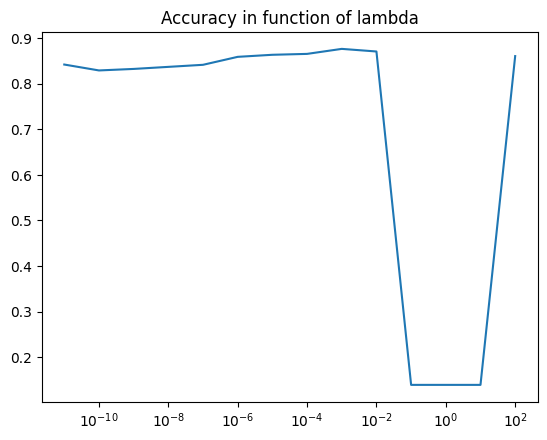

In [21]:
import matplotlib.pyplot as plt
plt.plot(lambdas,accs)
plt.xscale('log')
plt.title('Accuracy in function of lambda')
plt.show()

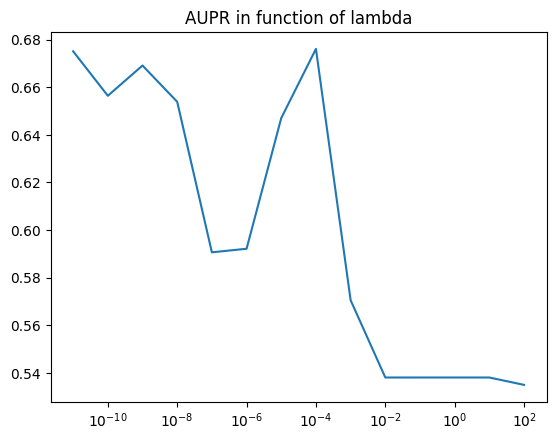

In [22]:
plt.plot(lambdas,aupr)
plt.xscale('log')
plt.title('AUPR in function of lambda')
plt.show()

### test with lambda_max

In [49]:
# Train the model with the best hyperparameter
print("lambda_max",lambda_max)
w_bfgs,b_bfgs = Komet.SVM_bfgs(X_cn,Y_cn,y,I,J,lambda_max)
s,t = Komet.compute_proba_Platt_Scalling(w_bfgs,X_cn,Y_cn,y,I,J)

lambda_max 0.001
L-BFGS time: 1.7617 seconds


In [50]:
# TEST 
I_test, J_test, y_test = Komet.load_datas("test.csv")
n_test = len(I_test)
print("len(test)",n_test)

len(test) 6011


In [51]:
#### TEST ####
# we test the model on the test set
# we compute a probability using weights (Platt scaling)
y_pred_test, proba_pred_test = Komet.compute_proba(w_bfgs,b_bfgs,s,t,X_cn,Y_cn,I_test,J_test)
# we compute the results
acc1,au_Roc,au_PR,acc_best,FP = Komet.results(y_test.cpu(),y_pred_test.cpu(),proba_pred_test.cpu())

accuracy (threshold 0.5)= 0.9530860185623169
roc AUC:0.8008677532083972
aupr= 0.4512337685744232
optimal threshold: 0.67166746
accuracy (best threshold)= 0.8702378869056702
Confusion Matrix with best threshold: 
 [[5012  696]
 [  84  219]]
False Positive Rate with best threshold:  0.12193412754029433
